In [1]:
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

from torch_geometric.loader import DataLoader
from CustomDataset import CustomDataset

%config InlineBackend.figure_format = 'png2x'
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'  # 'stix' is similar to Times New Roman
# If you want to use LaTeX to render all text (for more consistency)
plt.rcParams['text.usetex'] = True

plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['xtick.major.width'] = 0.5  # Set x major tick width to 2 points
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
additional_colors = [
    '#191970',  # Midnight Blue
    (0.498, 1.0, 0.831),  # Aqua Marine
    '#228B22',  # Forest Green
    '#FF7F50',  # Coral
    (0.855, 0.647, 0.125),  # Golden Rod
    '#FF1493',  # Deep Pink
    (0.901, 0.901, 0.980),  # Lavender
    '#A0522D',  # Sienna
    (0.0, 0.501, 0.501),  # Teal
    '#DA70D6'   # Orchid
]

colors += additional_colors

### Read ground truth and prediction

In [3]:
nt = 12

num_zones = 3

num_data = 200

# Ground truth
agg_Shedding_true = np.zeros((num_data, num_zones+1, nt))
agg_Shedding_pred = np.zeros((num_data, num_zones+1, nt))

# Read ground truth and prediction
for i in range(num_data):
    file_path  =f'../../res/IEEE_Case118/model_evaluation/agg_Shedding/true/true_{i+1}.csv'
    ground_truth = pd.read_csv(file_path, header=None, index_col=None)
    agg_Shedding_true[i, :, :] = ground_truth.values.copy()

    file_path  =f'../../res/IEEE_Case118/model_evaluation/agg_Shedding/pred/pred_{i+1}.csv'
    pred = pd.read_csv(file_path, header=None, index_col=None)
    agg_Shedding_pred[i, :, :] = pred.values.copy()

## One-on-one comparison

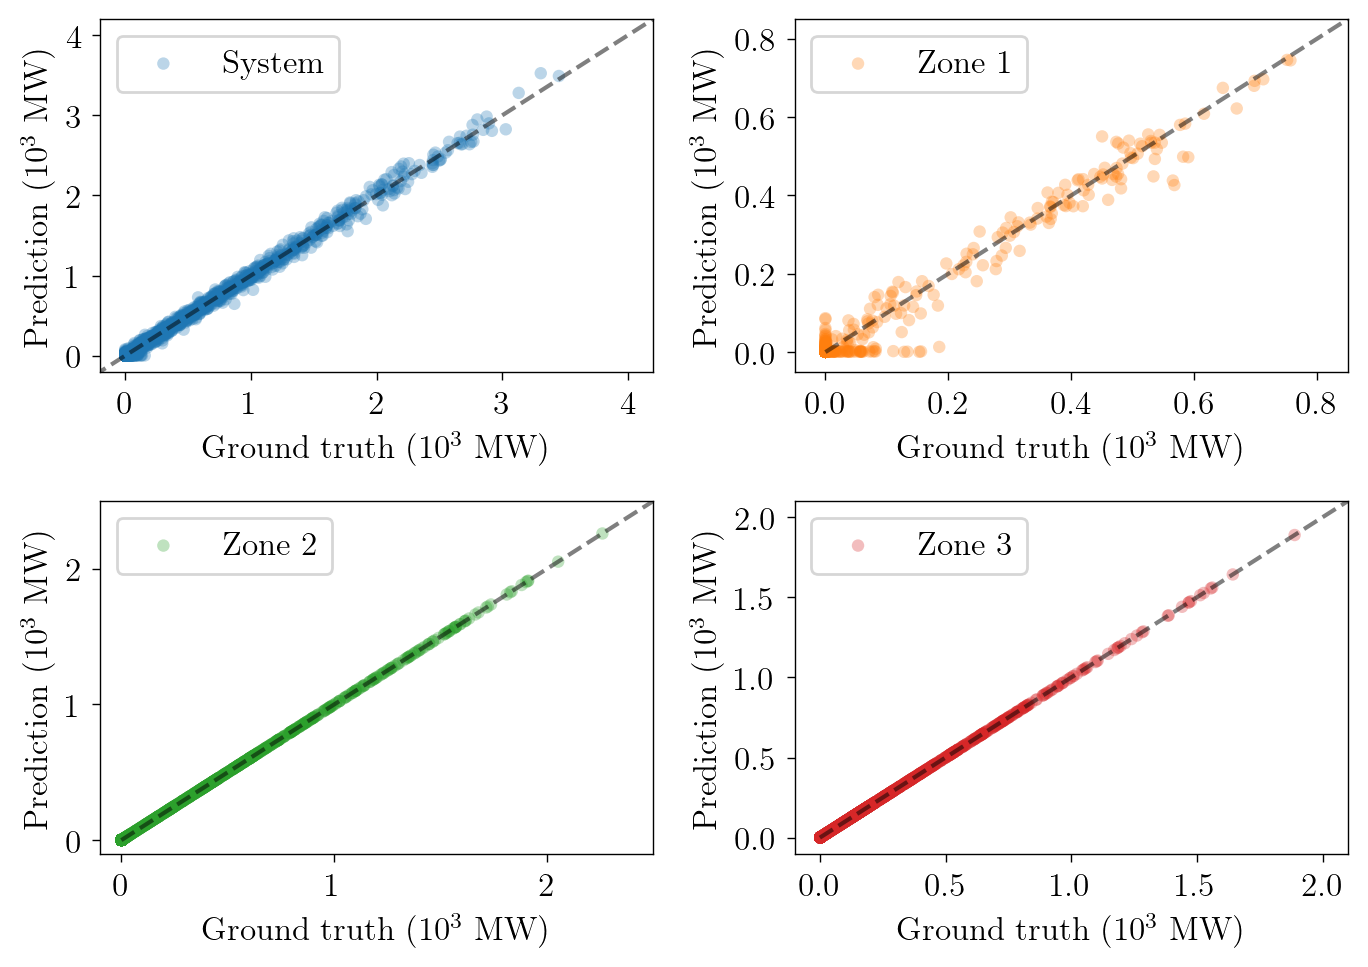

In [4]:
# System-level
fig = plt.figure(figsize=(7, 5))
x = np.linspace(-1, 10, 100)
y = x
ax1 = fig.add_subplot(221)
ax1.plot(x, y, 'k--', linewidth=1.5, alpha=0.5)
ax1.scatter(agg_Shedding_true[:, 0, :].flatten()/1000, agg_Shedding_pred[:, 0, :].flatten()/1000, 
            s=20, c=colors[0], marker='o', edgecolors='none', alpha=0.3, label='System')
ax1.set_xlim((-0.2, 4.2))
ax1.set_ylim((-0.2, 4.2))
ax1.set_xlabel('Ground truth ($10^3$ MW)')
ax1.set_ylabel('Prediction ($10^3$ MW)')
ax1.legend(loc='upper left')

# Zone 1
x = np.linspace(0, 10, 100)
y = x
ax2 = fig.add_subplot(222)
ax2.plot(x, y, 'k--', linewidth=1.5, alpha=0.5)
ax2.scatter(agg_Shedding_true[:, 1, :].flatten()/1000, agg_Shedding_pred[:, 1, :].flatten()/1000, 
            s=20, c=colors[1], marker='o', edgecolors='none', alpha=0.3, label='Zone 1')
ax2.set_xlim((-0.05, 0.85))
ax2.set_ylim((-0.05, 0.85))
ax2.set_xlabel('Ground truth ($10^3$ MW)')
ax2.set_ylabel('Prediction ($10^3$ MW)')
ax2.legend(loc='upper left')

# Zone 2
x = np.linspace(0, 10, 100)
y = x
ax3 = fig.add_subplot(223)
ax3.plot(x, y, 'k--', linewidth=1.5, alpha=0.5)
ax3.scatter(agg_Shedding_pred[:, 2, :].flatten()/1000, agg_Shedding_pred[:, 2, :].flatten()/1000, 
            s=20, c=colors[2], marker='o', edgecolors='none', alpha=0.3, label='Zone 2')
ax3.set_xlim((-0.1, 2.5))
ax3.set_ylim((-0.1, 2.5))
ax3.set_xlabel('Ground truth ($10^3$ MW)')
ax3.set_ylabel('Prediction ($10^3$ MW)')
ax3.legend(loc='upper left')

# Zone 3
x = np.linspace(0, 10, 100)
y = x
ax4 = fig.add_subplot(224)
ax4.plot(x, y, 'k--', linewidth=1.5, alpha=0.5)
ax4.scatter(agg_Shedding_pred[:, 3, :].flatten()/1000, agg_Shedding_pred[:, 3, :].flatten()/1000, 
            s=20, c=colors[3], marker='o', edgecolors='none', alpha=0.3, label='Zone 3')
ax4.set_xlim((-0.1, 2.1))
ax4.set_ylim((-0.1, 2.1))
ax4.set_xlabel('Ground truth ($10^3$ MW)')
ax4.set_ylabel('Prediction ($10^3$ MW)')
ax4.legend(loc='upper left')


plt.tight_layout()
plt.show()
plt.close('all')

## Calculate MRE

In [5]:
##############################################################################################################
############################# Set threshold = 200 based on plot above ########################################
##############################################################################################################
rela_err = np.zeros(agg_Shedding_true.shape)   # Array to store relative error
MRE = np.zeros((num_zones+1, nt))       # Array to store mean relative error
indices = np.where(agg_Shedding_true > 200)     # Only consider the case where ground truth > 200
rela_err[indices] = (agg_Shedding_true[indices] - agg_Shedding_pred[indices]) / agg_Shedding_true[indices] * 100 # Relative error
MRE = np.mean(np.abs(rela_err), axis=0)    # Mean relative error

## Testing data variation

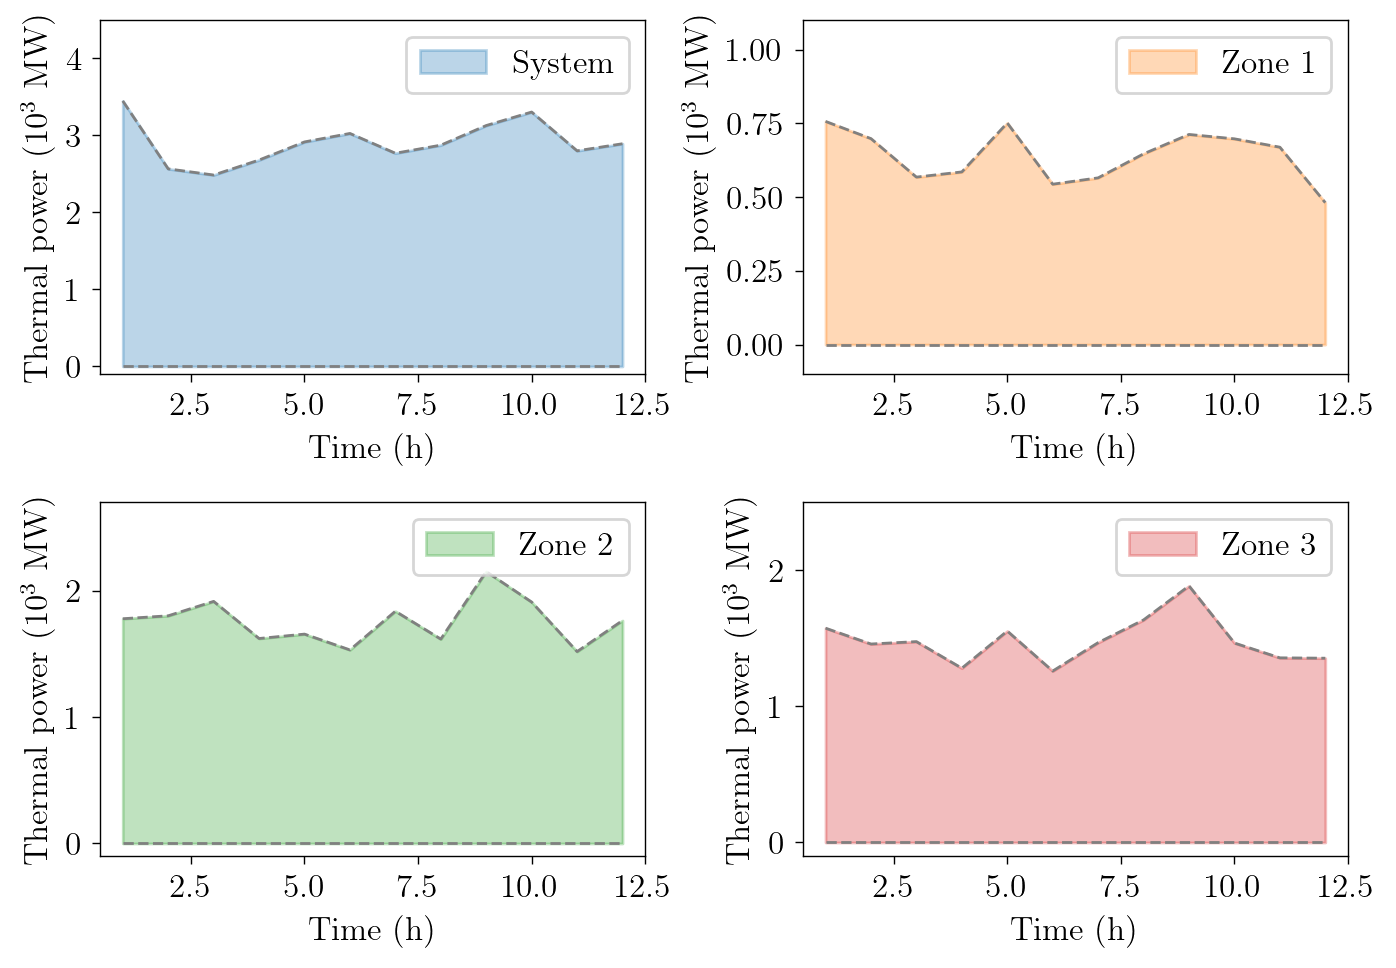

In [6]:
# Plot system-level results
fig = plt.figure(figsize=(7, 5))

ax1 = fig.add_subplot(221)
ax1.plot(np.arange(1, 13), agg_Shedding_true[:, 0, :].min(axis=0)/1000, linestyle='--', linewidth=1, color='gray')
ax1.plot(np.arange(1, 13), agg_Shedding_true[:, 0, :].max(axis=0)/1000, linestyle='--', linewidth=1, color='gray')
ax1.fill_between(np.arange(1, 13), agg_Shedding_true[:, 0, :].min(axis=0)/1000, agg_Shedding_true[:, 0, :].max(axis=0)/1000, 
                 color=colors[0], alpha=0.3, label='System')
ax1.set_xlim((0.5, 12.5))
ax1.set_ylim((-0.1, 4.5))
ax1.set_xlabel('Time (h)')
ax1.set_ylabel('Thermal power ($10^3$ MW)')
ax1.legend(loc='upper right')

ax2 = fig.add_subplot(222)
ax2.plot(np.arange(1, 13), agg_Shedding_true[:, 1, :].min(axis=0)/1000, linestyle='--', linewidth=1, color='gray')
ax2.plot(np.arange(1, 13), agg_Shedding_true[:, 1, :].max(axis=0)/1000, linestyle='--', linewidth=1, color='gray')
ax2.fill_between(np.arange(1, 13), agg_Shedding_true[:, 1, :].min(axis=0)/1000, agg_Shedding_true[:, 1, :].max(axis=0)/1000, 
                 color=colors[1], alpha=0.3, label='Zone 1')
ax2.set_xlim((0.5, 12.5))
ax2.set_ylim((-0.1, 1.1))
ax2.set_xlabel('Time (h)')
ax2.set_ylabel('Thermal power ($10^3$ MW)')
ax2.legend(loc='upper right')

ax3 = fig.add_subplot(223)
ax3.plot(np.arange(1, 13), agg_Shedding_true[:, 2, :].min(axis=0)/1000, linestyle='--', linewidth=1, color='gray')
ax3.plot(np.arange(1, 13), agg_Shedding_true[:, 2, :].max(axis=0)/1000, linestyle='--', linewidth=1, color='gray')
ax3.fill_between(np.arange(1, 13), agg_Shedding_true[:, 2, :].min(axis=0)/1000, agg_Shedding_true[:, 2, :].max(axis=0)/1000, 
                 color=colors[2], alpha=0.3, label='Zone 2')
ax3.set_xlim((0.5, 12.5))
ax3.set_ylim((-0.1, 2.7))
ax3.set_xlabel('Time (h)')
ax3.set_ylabel('Thermal power ($10^3$ MW)')
ax3.legend(loc='upper right')


ax4 = fig.add_subplot(224)
ax4.plot(np.arange(1, 13), agg_Shedding_true[:, 3, :].min(axis=0)/1000, linestyle='--', linewidth=1, color='gray')
ax4.plot(np.arange(1, 13), agg_Shedding_true[:, 3, :].max(axis=0)/1000, linestyle='--', linewidth=1, color='gray')
ax4.fill_between(np.arange(1, 13), agg_Shedding_true[:, 3, :].min(axis=0)/1000, agg_Shedding_true[:, 3, :].max(axis=0)/1000, 
                 color=colors[3], alpha=0.3, label='Zone 3')
ax4.set_xlim((0.5, 12.5))
ax4.set_ylim((-0.1, 2.5))
ax4.set_xlabel('Time (h)')
ax4.set_ylabel('Thermal power ($10^3$ MW)')
ax4.legend(loc='upper right')

plt.tight_layout()
plt.show()
plt.close('all')

## Zone-level MRE

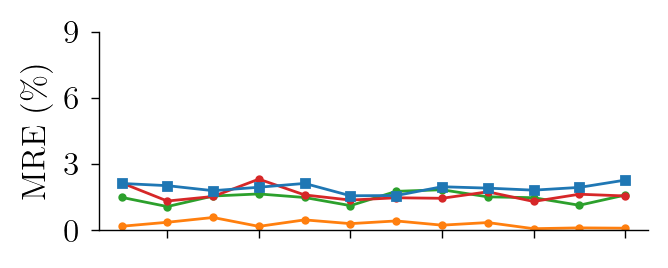

In [12]:
# fig = plt.figure(figsize=(3.5, 2))
fig = plt.figure(figsize=(3.5, 1.5))

ax = fig.add_subplot(111)
# ax.plot(np.arange(1, 13), MRE[1, :], color=colors[1], linewidth=1, marker='s', markersize=3, label='Zone i')
# ax.plot(np.arange(1, 13), MRE[2, :], color=colors[2], linewidth=1, marker='s', markersize=3, label='Zone ii')
# ax.plot(np.arange(1, 13), MRE[3, :], color=colors[3], linewidth=1, marker='s', markersize=3, label='Zone iii')
# ax.plot(np.arange(1, 13), MRE[0, :], color=colors[0], linewidth=1, marker='s', markersize=3, label='System')

ax.plot(np.arange(1, 13), MRE[1, :], color=colors[1], linewidth=1, marker='o', markersize=2, label='Zone i')
ax.plot(np.arange(1, 13), MRE[2, :], color=colors[2], linewidth=1, marker='o', markersize=2, label='Zone ii')
ax.plot(np.arange(1, 13), MRE[3, :], color=colors[3], linewidth=1, marker='o', markersize=2, label='Zone iii')
ax.plot(np.arange(1, 13), MRE[0, :], color=colors[0], linewidth=1, marker='s', markersize=3, label='System')


# ax.set_xlabel('Time step $t$ (h)')
ax.set_ylabel('MRE (\%)')
ax.set_xlim((0.5, 12.5))
ax.set_ylim(0, 9)
ax.set_xticks(np.arange(2, 13, 2))
ax.set_yticks(np.arange(0, 10, 3))
ax.set_xticklabels([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()
# fig.savefig(f'../../submission/118_agg_Shedding_MRE.png', bbox_inches='tight', dpi=300)
plt.close('all')